## TODO:  
- allow for total reads or coverage approach
- for total reads, a per chromosome (fastq entry) estimate of progress will be made
- calculate coverage as total reads x coverage value = total reads

In [1]:
import matplotlib as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

%matplotlib inline

In [2]:
#df = pd.read_csv('../raw_data/samples/raw_digest_df.csv')
df = pd.read_csv('../raw_data/samples/raw_digest_chr_1.fna.csv')
df.head()

,seq,start,end,strand,length,length_w_adapter,r1_id,r2_id
0,ATGTTGGTATGGGAGGAACAATATATGTACCATTTTTTAAAATCGA...,153,776,+,621,621,na,na
1,ATGAAATAAATTTAATTGAGCTTATTAGCTGGTTACCAGAAGGTAA...,772,1403,+,629,629,na,na
2,ATGTATAATAACAAATTACTATAGACAACTTTGACTATTTTTATAA...,1399,1567,+,166,166,na,na
3,ATGGTAGCACAAGAACCCCACAATCTCATAAAAGGAATGTGAAAAG...,1563,1737,+,172,172,na,na
4,ATGACCATTACTCGCCTACTAGGTTACTCTTATATTTGATCTTCTA...,1733,2634,+,899,899,na,na


<AxesSubplot:>

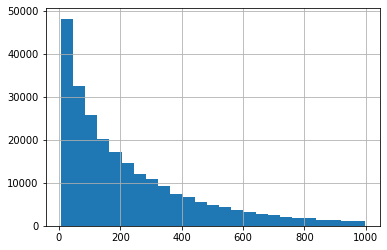

In [3]:
read_count = len(df)
df['length'].hist(bins=25)

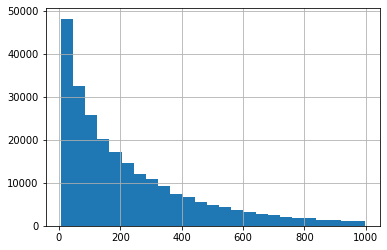

In [4]:
ax = df['length'].hist(bins=25)
fig = ax.get_figure()
fig.savefig('./raw_digest.pdf')

### define mean and sd (simulates size selection e.g., Blue-Pippin)

In [5]:
mean = 400
sd = 100
#total_reads = read_count * 20
total_reads = 300000

[334, 263, 515, 508, 527, 334, 381, 437, 410, 391, 560, 279, 311, 269, 364, 556, 483, 390, 404, 437, 444, 446, 475, 401, 454, 297, 274, 302, 557, 423, 446, 380, 397, 325, 186, 322, 266, 392, 341, 515, 323, 481, 617, 363, 411, 493, 480, 216, 553, 392]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

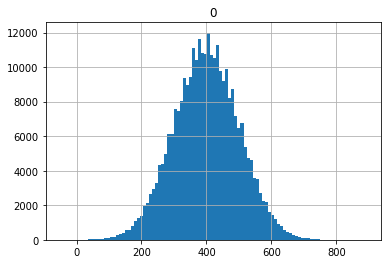

In [6]:
draw_ls = np.random.normal(loc=mean,scale=sd,size=total_reads)
draw_ls = [round(i) for i in draw_ls]
print(draw_ls[:50])

draw_dt = {}

for i in range(max(min(df['length']), min(draw_ls)), min(max(df['length']), max(draw_ls))+1):
    draw_dt[i] = draw_ls.count(i)

tmp_df = pd.DataFrame(draw_ls)
tmp_df.hist(bins=sd)

### sort df by length

In [7]:
df.sort_values(['length'], ascending=[True], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,seq,start,end,strand,length,length_w_adapter,r1_id,r2_id
0,ATGCAT,26589243,26589251,-,6,6,na,na
1,ATGCAT,27775279,27775287,-,6,6,na,na
2,ATGCAT,15527248,15527256,+,6,6,na,na
3,ATGCAT,15514382,15514390,+,6,6,na,na
4,ATGCAT,15506144,15506152,+,6,6,na,na


### sample actual reads (good for visual, but data object can be large)

In [8]:
sampled_seqs = pd.DataFrame(columns=['sequence', 'r1_id', 'r2_id', 'length'])

for length, draws in draw_dt.items():
    tmp_df =  df.loc[df['length'] == length]
    if len(tmp_df) == 0:
        continue
    sampled_df = tmp_df.sample(n=draws, replace=True)
    sampled_seqs = pd.concat([sampled_seqs, sampled_df])

print(f'the length of sample_seqs is {len(sampled_seqs)}')

the length of sample_seqs is 299989


<AxesSubplot:>

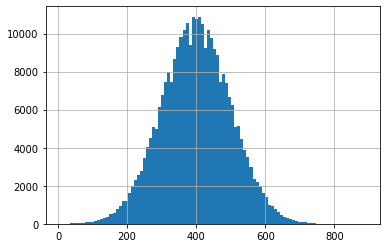

In [9]:
sampled_seqs['length'].hist(bins=sd)

### sample reads using intersection of fragment/sampling distributions
automatically size to include all fragments in mean + sd range  
this mimics real gel size selection as all of the target fragments should be included near the mean while the shorter fragments, which are likely to be very abundant, will be represented as a fraction

In [13]:
# try creating draw_ls until mean + 2sd are not hindered by number of draws
# grow sample size by 10 percent each iteration

total_reads = 10
target = 2*sd
keep_going = True

while keep_going is True:
    keep_going = False
    draw_ls = np.random.normal(loc=mean,scale=sd,size=total_reads)
    draw_ls = [round(i) for i in draw_ls]
    for i in range(mean, mean + target):
        len_count = df[(df.length == i) & (df.strand == '+')].shape[0]
        if len_count > draw_ls.count(i):
            total_reads = round(total_reads*1.1)
            keep_going = True
            break

In [14]:
print(total_reads)

94731


In [15]:
draw_dt = {}
for i in range(min(draw_ls), max(draw_ls)+1):
    draw_counts = draw_ls.count(i)
    data_counts = df[df.length == i].shape[0]
    draw_dt[i] = min(draw_counts, data_counts)

In [16]:
#draw_dt = {}

#for i in range(max(min(df['length']), min(draw_ls)), min(max(df['length']), max(draw_ls))+1):
#    draw_dt[i] = draw_ls.count(i)

In [17]:
sampled_seqs = pd.DataFrame(columns=['sequence', 'r1_id', 'r2_id', 'length'])

for length, draws in draw_dt.items():
    tmp_df =  df.loc[df['length'] == length]
    if len(tmp_df) == 0:
        continue
    sampled_df = tmp_df.sample(n=draws, replace=True)
    sampled_seqs = pd.concat([sampled_seqs, sampled_df])

print(f'the length of sample_seqs is {len(sampled_seqs)}')

the length of sample_seqs is 63296


### original fragments

<AxesSubplot:>

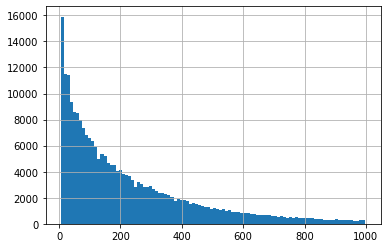

In [18]:
df['length'].hist(bins=sd)

### original fragments (in range of 100 to 700)

<AxesSubplot:>

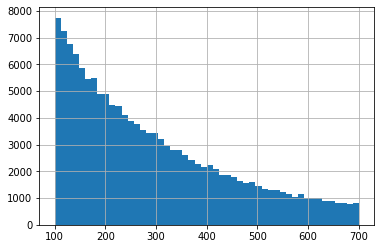

In [19]:
df['length'].hist(range=[100, 700], bins=50)

### sampling distribution

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

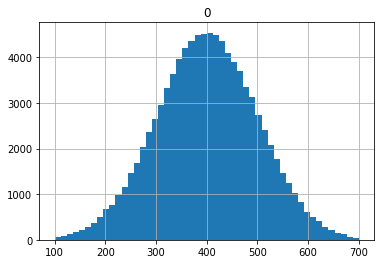

In [20]:
tmp_df = pd.DataFrame(draw_ls)
tmp_df.hist(range=[100, 700], bins=50)

### reads actually sampled (intersection)

<AxesSubplot:>

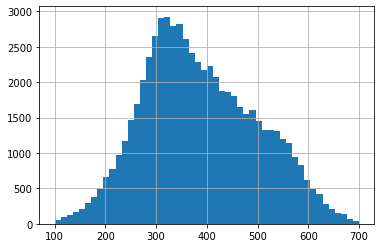

In [21]:
sampled_seqs['length'].hist(range=[100, 700], bins=50)

### sample idices (more compact)

In [22]:
sampled_seqs = pd.DataFrame(columns=['sequence', 'r1_id', 'r2_id', 'length'])
counts = []

for length, draws in draw_dt.items():
    tmp_df =  df.loc[df['length'] == length]
    if len(tmp_df) == 0:
        continue
    indices = [i for i in range(len(tmp_df))]
    sampled_idx = random.choices(indices, k=draws)
    counts += [sampled_idx.count(idx) for idx in indices]
    #tmp_df['counts'] = new_col
    sampled_seqs = pd.concat([sampled_seqs, tmp_df])

sampled_seqs['counts'] = counts

print(f'the length of sample_seqs is {len(sampled_seqs)}')
print(sampled_seqs['counts'].sum())

the length of sample_seqs is 236732
63296


### drop the unused reads

In [23]:
index_names = sampled_seqs[sampled_seqs['counts'] == 0].index

sampled_seqs.drop(index_names, inplace=True)

print(f'the length of sample_seqs is {len(sampled_seqs)}')
print(sampled_seqs['counts'].sum())
sampled_seqs.head()

the length of sample_seqs is 43645
63296


,sequence,r1_id,r2_id,length,seq,start,end,strand,length_w_adapter,counts
20111,NaN,na,na,19,ATGGTAAGCACAACGCCAT,14021894.0,14021915.0,+,19.0,1
36977,NaN,na,na,34,ATGTCCGACGTGTAGGACAAGCCTTCGTAGTCAT,28061303.0,28061339.0,-,34.0,1
40953,NaN,na,na,38,ATGTCCTGCAGTTAATCGTTGATGTACTTGTAAATCAT,7040452.0,7040492.0,-,38.0,1
42347,NaN,na,na,39,ATGGGCATATGGCGGCTGGAGTTTAGCCGCAGGGTGCAT,22876159.0,22876200.0,-,39.0,1
43069,NaN,na,na,40,ATGACACTGAATTGCAAGGTCTTAGCGAGCAGTTGGTCAT,26943497.0,26943539.0,+,40.0,1


### create sampling distribution by expanding sampled_seqs dataframe

In [24]:
histogram_seqs = pd.DataFrame(columns=['length'])
length_ls = []

for idx, row in sampled_seqs.iterrows():
    length_ls.extend([row['length'] for i in range(row['counts'])])

histogram_seqs['length'] = length_ls

print(len(histogram_seqs))

63296


<AxesSubplot:>

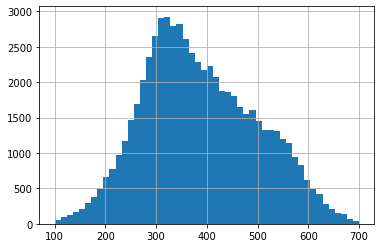

In [25]:
histogram_seqs['length'].hist(range=[100, 700], bins=50)